# RMSD Restraint testing

In this notebook, we will perform some basic tests of our prototype RMSD restraints in sire.

In [1]:
import sire as sr
import matplotlib.pyplot as plt
import numpy as np
import openmm as mm
import openmm.app as app
import openmm.unit as unit
from sys import stdout
# import pytest

In [2]:
def obtain_rmsd(mols, selection_str="atomname CA, C, N"):

    rmsd_df = mols.trajectory().rmsd(selection_str, to_pandas=True)

    return rmsd_df['rmsd'].to_numpy()

In [3]:
colours = {0.0:'r', 0.25:'g', 0.5:'orange', 0.75:'grey', 1.0:'b'}

## Python source code

https://github.com/BenTanYK/sire/blob/ac4542c135d2325b94e63896e06be4c155b07f67/src/sire/restraints/_restraints.py#L760

In [3]:
def rmsd(mols, atoms, ref=None, k=None, r0=None, name=None, map=None):
    """
    Create a set of RMSD restraints for the atoms specified in
    'atoms' that are contained in the container 'mols', using the
    passed values of 'k' and flat-bottom potential
    well-width 'r0' for the restraints. Note that 'k' values
    correspond to half the force constants for the harmonic
    restraints, because the harmonic restraint energy is defined as
    k*(rmsd - r0)**2 (hence the force is defined as 2*(rmsd - r0)).

    The RMSD calculation is perfomed by default using the position
    of mols. Optionally, a different state of the system can be
    supplied as a reference by passing the 'ref' argument.

    If 'r0' is not specified, then a simple harmonic restraint
    is used.

    If 'k' is not specified, then a default of 150 kcal mol-1 A-2
    will be used.

    Parameters
    ----------
    mols : sire.system._system.System
        The system containing the atoms.

    atoms : SireMol::Selector<SireMol::Atom>
        The atoms to restrain.

    ref : sire.system._system.System
        The system from which the reference positions for the RMSD calculation
        are extracted from. If None, this will default to the current
        state of mols.    

    k : str or SireUnits::Dimension::GeneralUnit or, optional
        The force constant for the RMSD restraints.
        If None, this will default to 150 kcal mol-1 A-2.
        Default is None.

    r0 : str or SireUnits::Dimension::GeneralUnit, optional
        The width of the flat bottom restraint. If None, this is zero
        and a simple harmonic restraint is used.
        Default is None.

    Returns
    -------
    RMSDRestraints : SireMM::RMSDRestraints
        A container of RMSD restraints, where the first restraint is
        the RMSDRestraint created. The RMSD restraint created can be
        extracted with RMSDRestraints[0].
    """
    from .. import u
    from ..base import create_map
    from ..mm import RMSDRestraint, RMSDRestraints

    map = create_map(map)

    if k is None:
        k = u("150 kcal mol-1 A-2")
    else:
        k = u(k)

    if r0 is None:
        r0 = u("0")
    else:
        r0 = u(r0)

    atoms = _to_atoms(mols, atoms)
    mols = mols.atoms()

    if name is None:
        restraints = RMSDRestraints()
    else:
        restraints = RMSDRestraints(name=name)

    # Set default reference positions to mols
    if ref is None:
        ref = mols
    else:
        try:
            ref = ref.atoms()
        except AttributeError:
            raise TypeError("The reference state must be a complete system.")

    # Generate list of all positions as reference for RMSD calculation
    ref_pos = ref.atoms().property("coordinates")

    restraints.add(RMSDRestraint(mols.find(atoms), ref_pos, k, r0))

    return restraints

## Basic tests (included in sire tests directory)

In [3]:
def test_default_rmsd_restraints_setup(ala_mols):
    """Tests that rmsd restraints can be set up correctly with default parameters."""
    mols = ala_mols.clone()
    restraints = sr.restraints.rmsd(mols=mols, atoms=[0, 1, 2, 3, 4])
    assert restraints.num_restraints() == 1
    assert restraints[0].atoms() == [0, 1, 2, 3, 4]
    assert restraints[0].k().value() == 150.0
    assert restraints[0].r0().value() == 0.0

def test_rmsd_restraint_custom_k(ala_mols):
    """Tests that rmsd restraints can be set up correctly with custom k."""
    mols = ala_mols.clone()
    restraints = sr.restraints.rmsd(
        mols=mols, atoms=[0, 1, 2, 3, 4], k="10 kcal mol-1 A-2"
    )
    assert restraints.num_restraints() == 1
    assert restraints[0].atoms() == [0, 1, 2, 3, 4]
    assert restraints[0].k().value() == 10.0
    assert restraints[0].r0().value() == 0.0

def test_rmsd_restraint_custom_k_and_r0(ala_mols):
    """Tests that rmsd restraints can be set up correctly with custom k and r0."""
    mols = ala_mols.clone()
    restraints = sr.restraints.rmsd(
        mols=mols, atoms="atomname CA, C, N", k="10 kcal mol-1 A-2", r0="1 A"
    )
    assert restraints.num_restraints() == 1
    assert restraints[0].k().value() == 10.0
    assert restraints[0].r0().value() == 1.0

def test_rmsd_restraint_custom_k_and_r0_and_ref(ala_mols):
    """Tests that rmsd restraints can be set up correctly with custom k, r0 and reference state."""
    mols = ala_mols.clone()
    ref = mols.clone().minimisation().run().commit()
    restraints = sr.restraints.rmsd(
        mols=mols, atoms="atomname CA, C, N", k="10 kcal mol-1 A-2", r0="1 A", ref=ref
    )
    assert restraints.num_restraints() == 1
    assert mols.count() == ref.count()
    assert restraints[0].k().value() == 10.0
    assert restraints[0].r0().value() == 1.0

ala_mols = sr.load(['structures/ala.top', 'structures/ala.crd'])
test_default_rmsd_restraints_setup(ala_mols)
test_rmsd_restraint_custom_k(ala_mols)
test_rmsd_restraint_custom_k_and_r0(ala_mols)
test_rmsd_restraint_custom_k_and_r0_and_ref(ala_mols)

Extract property     98%       0.5 s 4184.0 its / s          


### Measuring the RMSD of a restrained structure

Apply the restraint potential $\rho \cdot k \cdot \text{step}(\delta) \cdot \delta^2; \quad \delta = (\text{rmsd} - \text{r}_\circ) $, where $\text{r}_\circ$ = 0.5 Å

#### DCAF16

Calculate RMSD                 5.0 s   99.5 its / s          


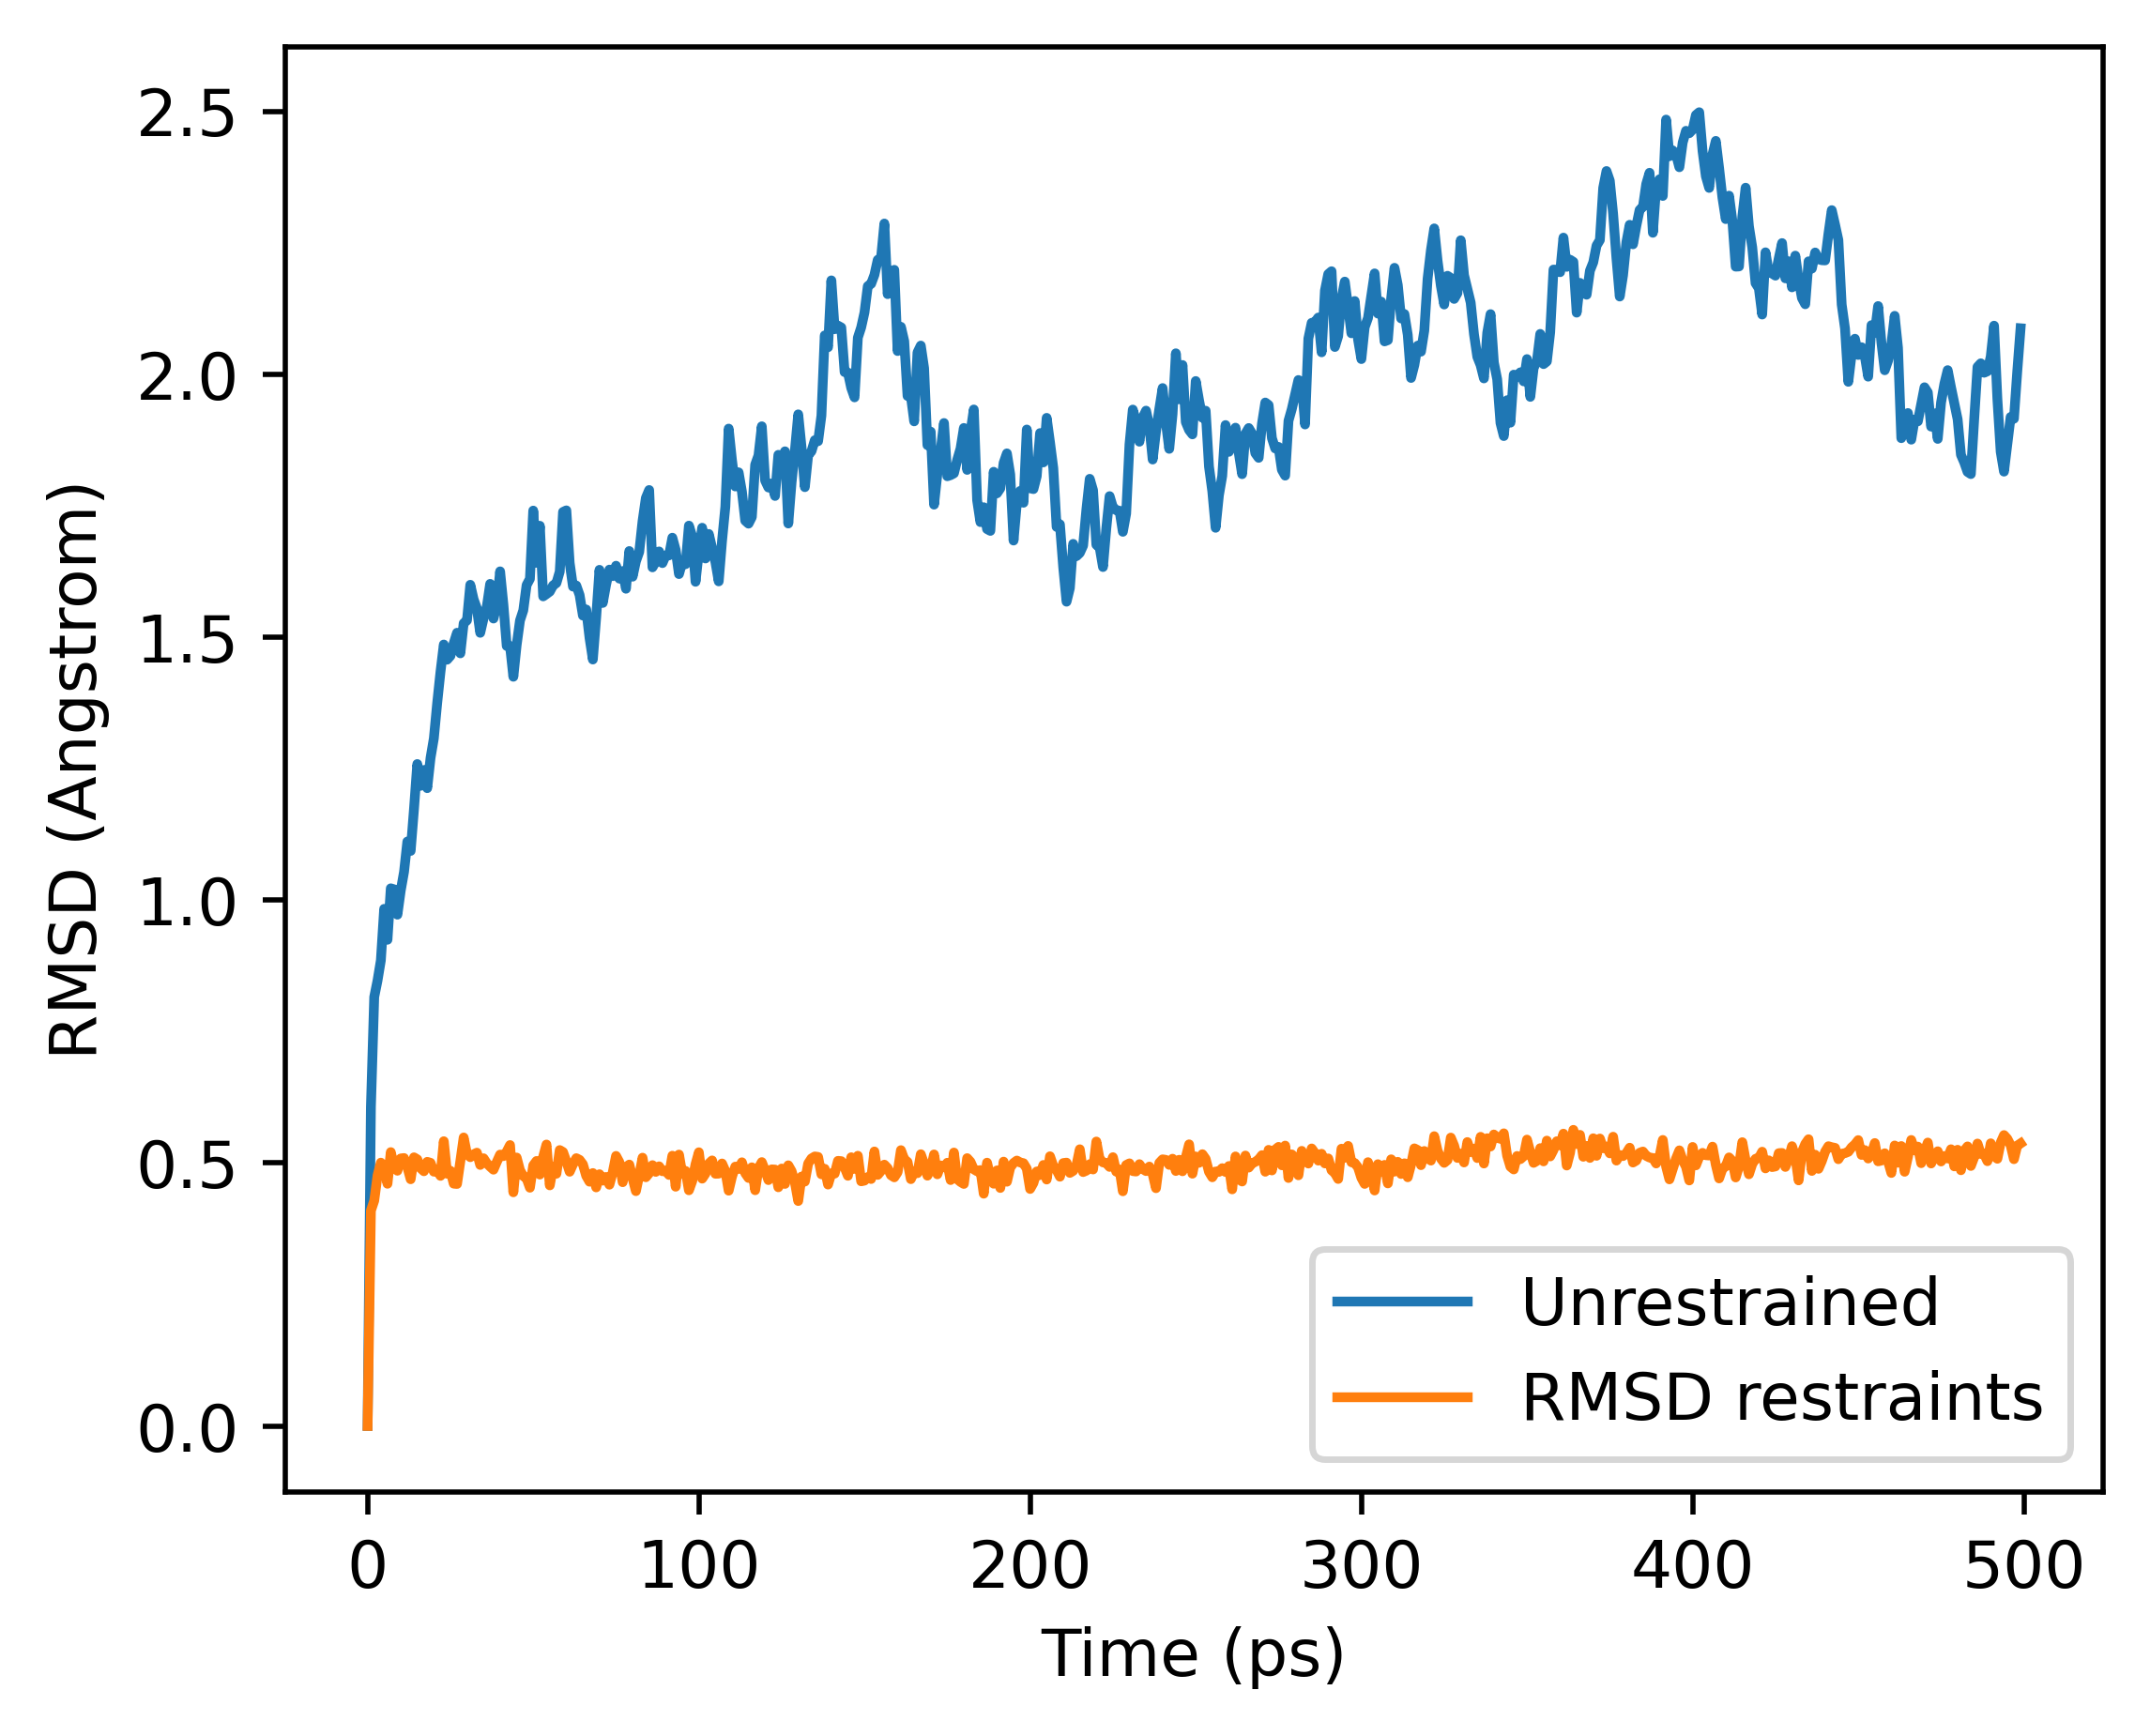

In [7]:
# Run unrestrained MD
mols = sr.load(['structures/DCAF16.prmtop', 'structures/DCAF16.inpcrd'])
mols = mols.minimisation().run().commit()
d = mols.dynamics(timestep="4fs", temperature="25oC")
d.run("500ps", "1ps")
mols = d.commit()
rmsd_unrestrained = obtain_rmsd(mols)

# Run restrained MD
mols_restr = sr.load(['structures/DCAF16.prmtop', 'structures/DCAF16.inpcrd'])
restraints = sr.restraints.rmsd(mols_restr, atoms="atomname CA, C, N", k="400 kcal mol-1 A-2", r0="0.05 A")
mols_restr = mols_restr.minimisation(restraints=restraints).run().commit()
d_restr = mols_restr.dynamics(timestep="4fs", temperature="25oC", restraints=restraints)
d_restr.run("500ps", "1ps")
mols_restr = d_restr.commit()
rmsd_restrained = obtain_rmsd(mols_restr)

# Plot RMSD
plt.figure(figsize=(5,4), dpi=500)
plt.plot(rmsd_unrestrained, label='Unrestrained')
plt.plot(rmsd_restrained, label='RMSD restraints')
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (Angstrom)')
plt.legend()
plt.show()

#### BD2

Calculate RMSD                 2.0 s  254.2 its / s          


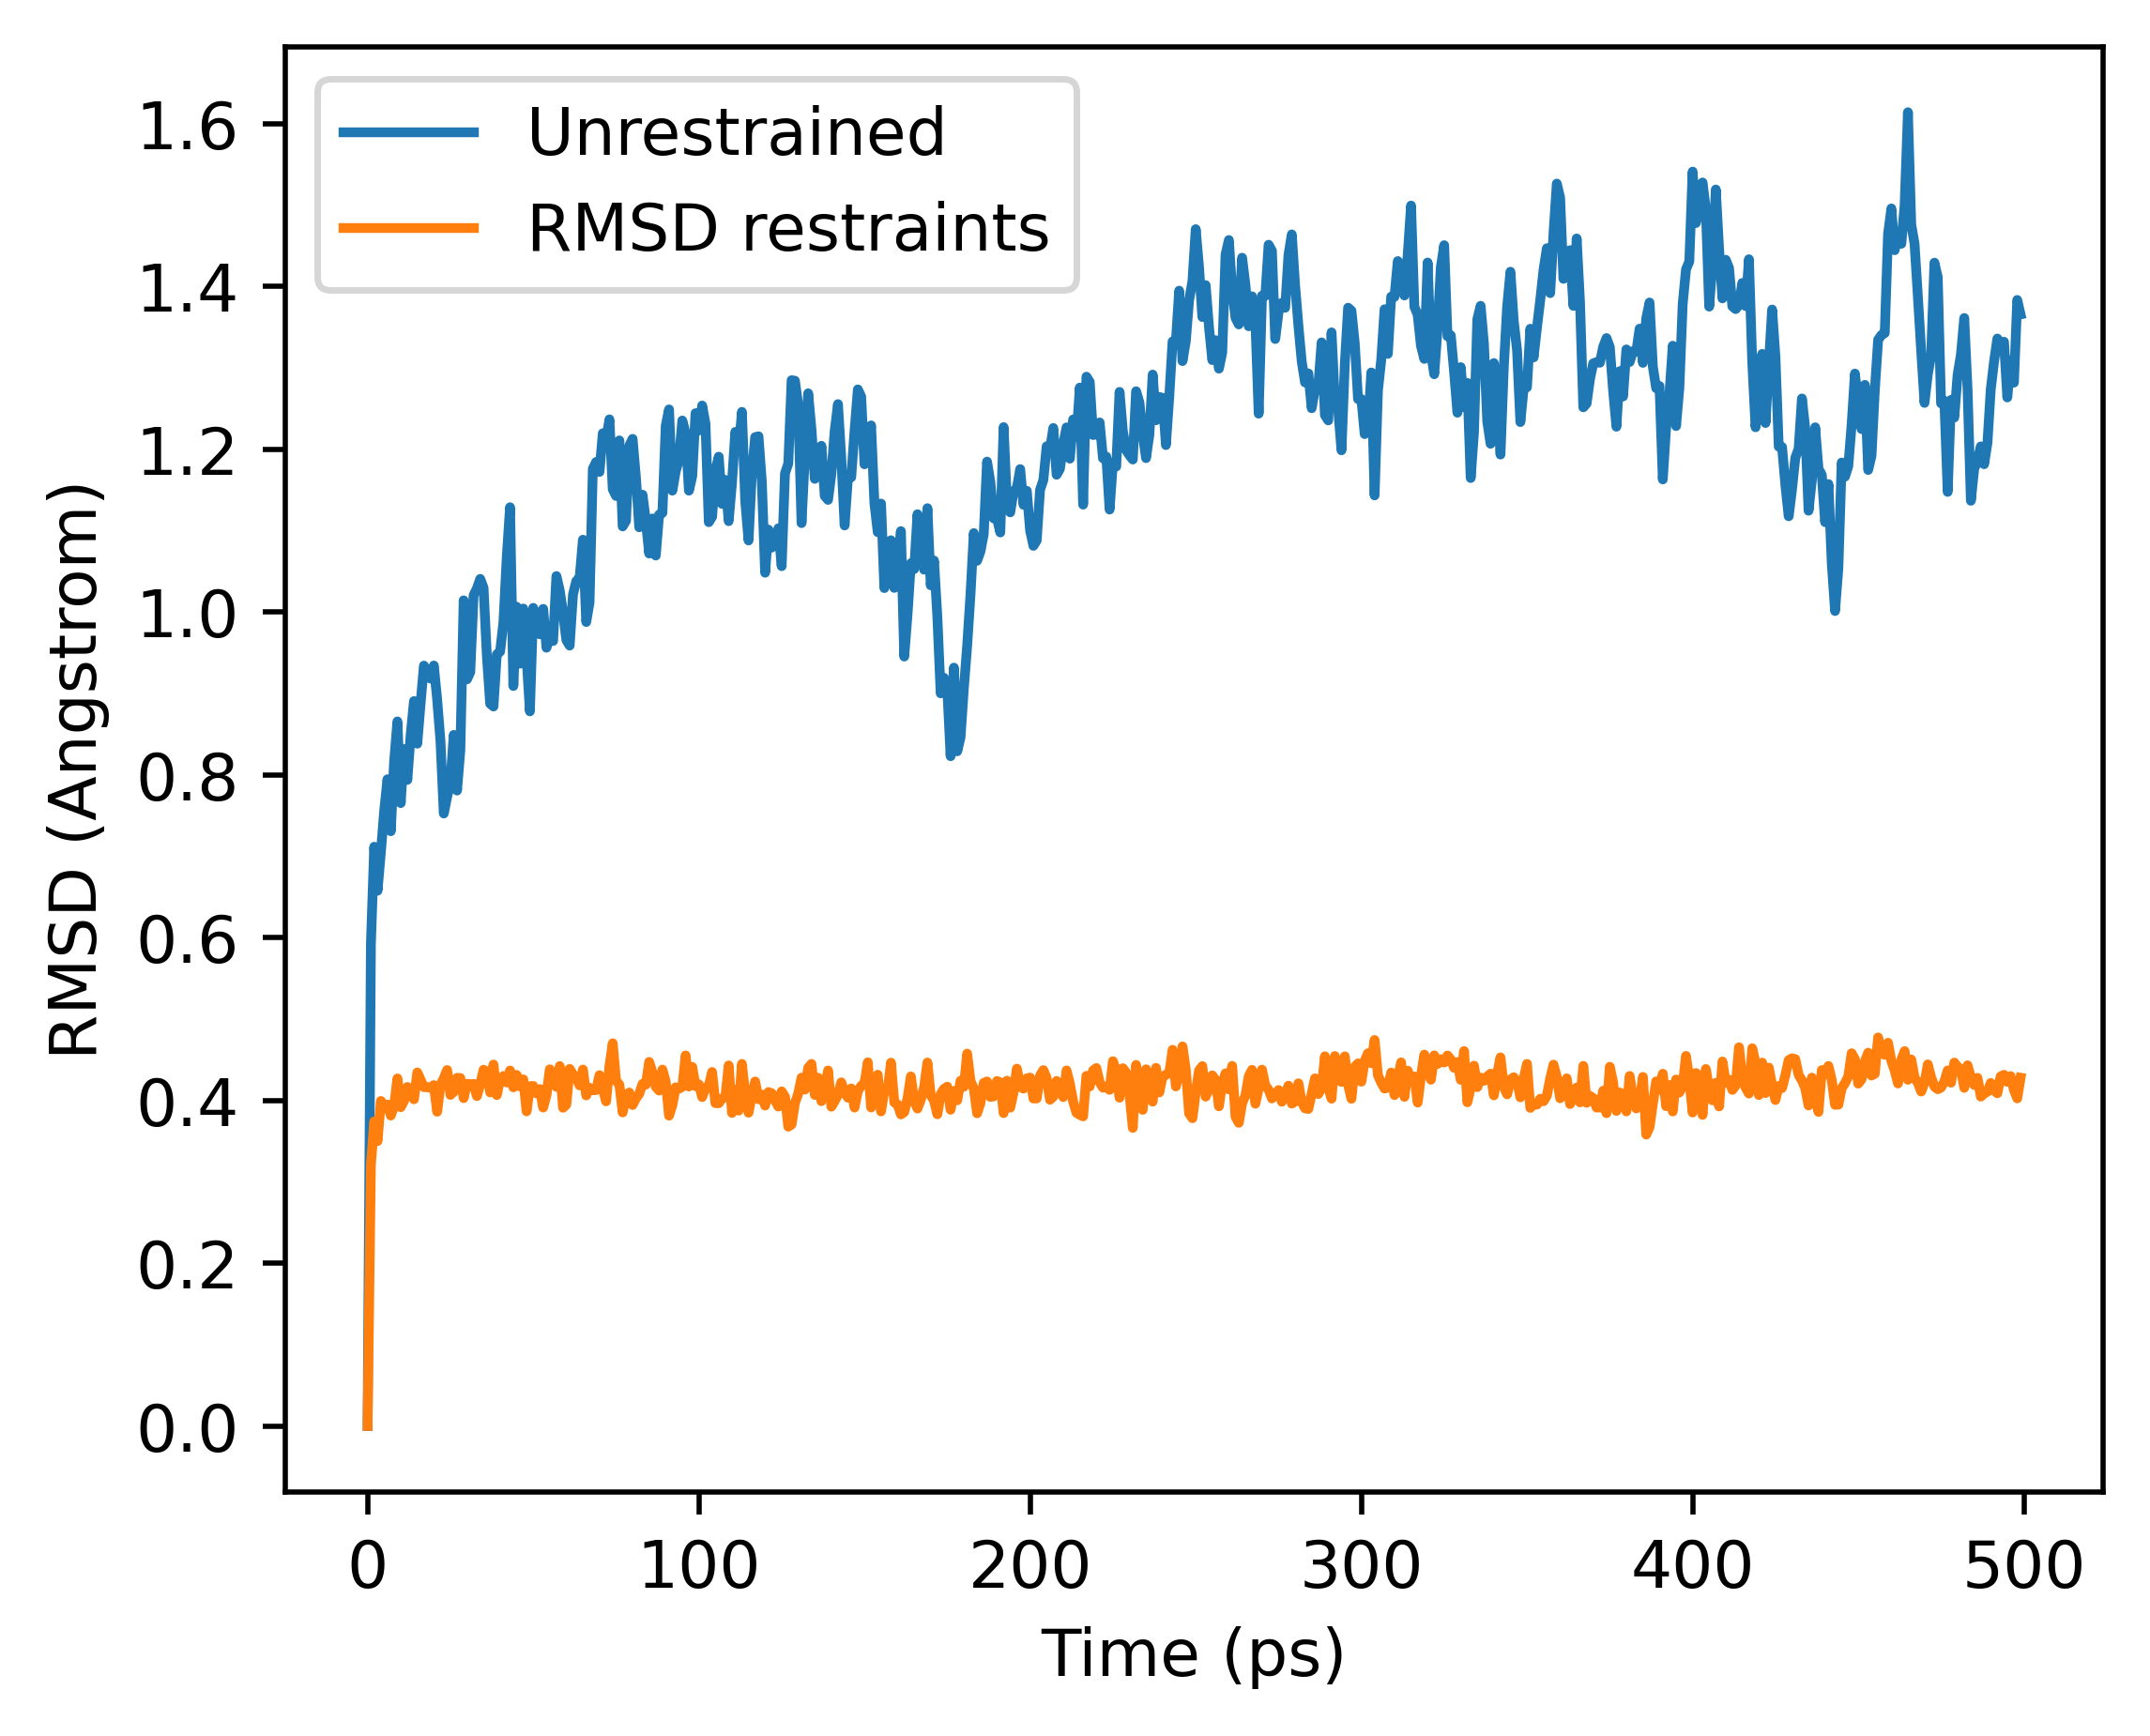

In [9]:
# Run unrestrained MD
mols = sr.load(['structures/BD2.prmtop', 'structures/BD2.inpcrd'])
mols = mols.minimisation().run().commit()
d = mols.dynamics(timestep="4fs", temperature="25oC")
d.run("500ps", "1ps")
mols = d.commit()
rmsd_unrestrained = obtain_rmsd(mols)

# Run restrained MD
mols_restr = sr.load(['structures/BD2.prmtop', 'structures/BD2.inpcrd'])
restraints = sr.restraints.rmsd(mols_restr, atoms="atomname CA, C, N", k="300 kcal mol-1 A-2")
mols_restr = mols_restr.minimisation(restraints=restraints).run().commit()
d_restr = mols_restr.dynamics(timestep="4fs", temperature="25oC", restraints=restraints)
d_restr.run("500ps", "1ps")
mols_restr = d_restr.commit()
rmsd_restrained = obtain_rmsd(mols_restr)

# Plot RMSD
plt.figure(figsize=(5,4), dpi=500)
plt.plot(rmsd_unrestrained, label='Unrestrained')
plt.plot(rmsd_restrained, label='RMSD restraints')
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (Angstrom)')
plt.legend()
plt.show()

## Testing multiple restraints

- Generate separate restraints containers for each of the regions to be restrained.
- For now, multiple restraints in a single container are not supported
- Restrain the DDB1-binding region and interface region in DCAF16 with different RMSD restraints

dynamics                  35 s  356.6 steps / s          


INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
/home/benedicttan/miniconda3/envs/openbiosim-dev/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/benedicttan/miniconda3/envs/openbiosim-dev/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


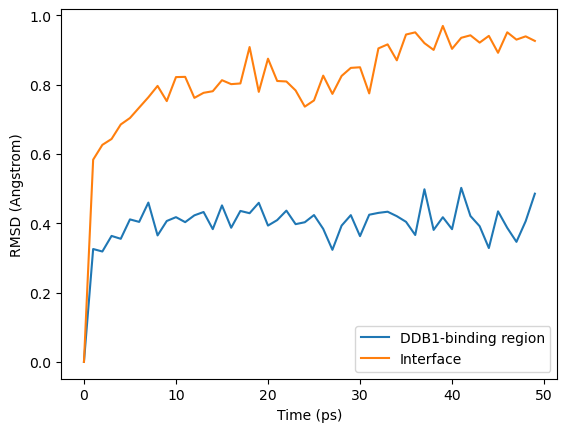

In [3]:
# Run restrained MD with DCAF16-binding restraints
mols = sr.load(['structures/DCAF16.prmtop', 'structures/DCAF16.inpcrd'])

DDB1_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N and resnum 70:115', k="100 kcal mol-1 A-2", name="DDB1")
RMSD_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N and not resnum 70:115', k="60 kcal mol-1 A-2", r0='0.5 A', name="RMSD")

mols = mols.minimisation(restraints=[DDB1_restraints, RMSD_restraints]).run().commit()
d_restr = mols.dynamics(timestep="4fs", temperature="25oC", restraints=[DDB1_restraints, RMSD_restraints])
d_restr.run("50ps", "1ps")
mols = d_restr.commit()

rmsd_DDB1 = obtain_rmsd(mols, selection_str='atomname CA, C, N and resnum 70:115')
rmsd_alch = obtain_rmsd(mols, selection_str='atomname CA, C, N and not resnum 70:115')

plt.plot(rmsd_DDB1, label='DDB1-binding region')
plt.plot(rmsd_alch, label='Interface')
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (Angstrom)')
plt.legend()
plt.show()

### Restraints with k=0

dynamics                  35 s 1447.7 steps / s          


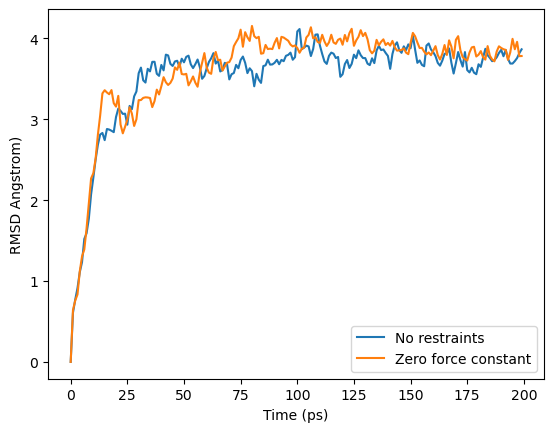

In [39]:
mols = sr.load('structures/BD2.bss')
mols = mols["molecule property is_perturbable"]
mols = sr.morph.link_to_reference(mols)
mols = mols.minimisation().run().commit()
d = mols.dynamics(timestep="4fs", temperature="25oC")
d.run("200ps", "1ps")
mols = d.commit()
rmsd_unrestrained = obtain_rmsd(mols)

mols = sr.load('structures/BD2.bss')
mols = mols["molecule property is_perturbable"]
mols = sr.morph.link_to_reference(mols)
RMSD_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N', k=f"0 kcal mol-1 A-2", name="RMSD")
mols = mols.minimisation().run().commit()
d = mols.dynamics(timestep="4fs", temperature="25oC", restraints=RMSD_restraints)
d.run("200ps", "1ps")
mols = d.commit()
rmsd_k0 = obtain_rmsd(mols, selection_str='atomname CA, C, N')

plt.plot(rmsd_unrestrained, label='No restraints')
plt.plot(rmsd_k0, label='Zero force constant')
plt.ylabel('RMSD Angstrom)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()

## Alchemical RMSD restraints

Testing RMSD restraints using lambda lever code to adjust the alchemical parameter. 

Let's observe the expected system behaviour by manually setting the expected force constant values for $\lambda = 1.0$, $\lambda = 0.5$ and $\lambda = 0.0$ with $k$ set to 100 kcal/mol/Angstrom^2

In [16]:
rmsd_data = {}

l_values = [0.0, 0.5, 1.0]

for lambda_value in l_values:

    mols = sr.load('structures/BD2_merged.bss')
    mols = mols["molecule property is_perturbable"]
    mols = sr.morph.link_to_reference(mols)

    k = int(40*(1-lambda_value))

    RMSD_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N', k=f"{k} kcal mol-1 A-2", name="RMSD")

    mols = mols.minimisation(restraints=RMSD_restraints).run().commit()
    d = mols.dynamics(timestep="4fs", temperature="25oC", restraints=RMSD_restraints)
    
    d.randomise_velocities()
    d.run("50ps", "1ps")
    mols = d.commit()
    # d.to_xml(f"xml_files/{lambda_value}_no_rho.xml")

    RMSD = obtain_rmsd(mols, selection_str='atomname CA, C, N')
    rmsd_data[lambda_value] = RMSD
    mols.delete_all_frames()

dynamics                 8.6 s 1448.3 steps / s          


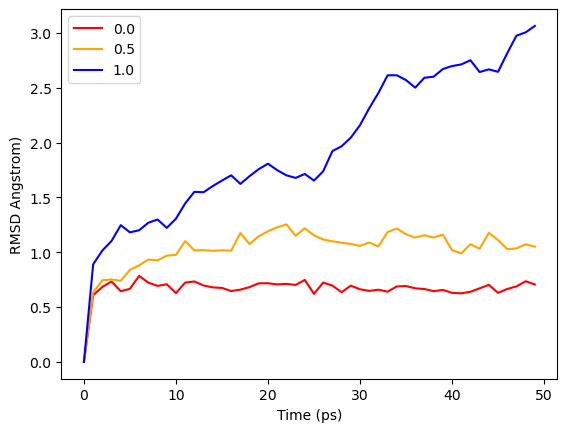

In [17]:
for l in l_values: 
    
    plt.plot(rmsd_data[l], label=l, c=colours[l])
    
plt.ylabel('RMSD Angstrom)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()

Now let's try running the equivalent dynamics by scaling the alchemical parameter:

In [7]:
mols_alch = sr.load('structures/BD2_merged.bss')
mols_alch = mols_alch["molecule property is_perturbable"]
mols_alch = sr.morph.link_to_reference(mols_alch)

RMSD_restraints = sr.restraints.rmsd(mols_alch, atoms='atomname CA, C, N', k="40 kcal mol-1 A-2", name="RMSD")

# Create lambda schedule
l = sr.cas.LambdaSchedule()
l.add_stage("turn_off_rmsd_restraints", l.initial())
l.set_equation(stage="turn_off_rmsd_restraints", lever="RMSD",
               equation=1-l.lam())

rmsd_data_alch = {} # Store sampled RMSD values

l_values = [0.0, 0.5, 1.0]

for lambda_value in l_values:

    # turn l into the lambda value by dividing by 100
    lambda_value = np.round(lambda_value, 4)
    print(f"\nSimulating lambda={lambda_value:.2f}")

    # Save starting input file
    # sr.save(mols_alch, f"traj_files/lambda{int(10*lambda_value)}", format=["prmtop", "inpcrd"])

    mols_alch = mols_alch.minimisation(lambda_value=lambda_value, schedule=l, restraints=RMSD_restraints).run().commit()
    d = mols_alch.dynamics(timestep="4fs", temperature="25oC", restraints=RMSD_restraints, schedule=l,
                            lambda_value=lambda_value)
    
    d.randomise_velocities() 
    d.run("50ps", "1ps")
    mols_alch = d.commit()

    # d.to_xml(f"xml_files/{lambda_value}.xml")

    # Save to .dcd file
    # sr.save(mols_alch.trajectory(), f"traj_files/lambda{int(10*lambda_value)}", format=["DCD"])

    RMSD = obtain_rmsd(mols_alch, selection_str='atomname CA, C, N')
    rmsd_data_alch[lambda_value] = RMSD
    mols_alch.delete_all_frames()

dynamics                 8.5 s 1469.6 steps / s          


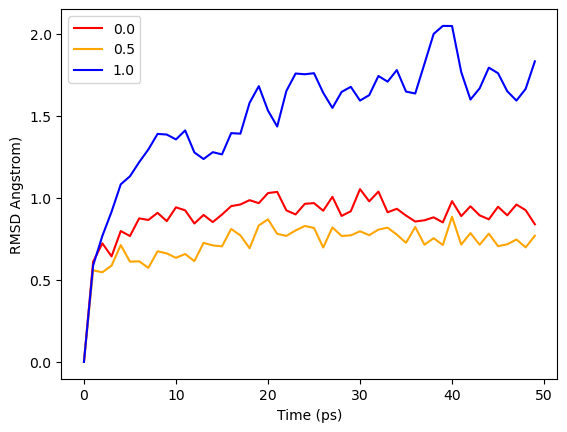

In [8]:
for l in l_values: 
    
    plt.plot(rmsd_data_alch[l], label=l, c=colours[l])
    # plt.plot(rmsd_data[l], linestyle='dotted', c=colours[l])
        
plt.ylabel('RMSD Angstrom)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()

#### Scaling multiple restraints in a single container

In [4]:
mols_double_restraint = sr.load('structures/BD2_merged.bss')
mols_double_restraint = mols_double_restraint["molecule property is_perturbable"]
mols_double_restraint = sr.morph.link_to_reference(mols_double_restraint)

RMSD_restraints = sr.restraints.rmsd(mols_double_restraint, atoms='atomname CA, C, N and resnum 1:55', k="40 kcal mol-1 A-2", name="RMSD")
restraints1 = sr.restraints.rmsd(mols_double_restraint, atoms='atomname CA, C, N and resnum 56:110', k="40 kcal mol-1 A-2")
RMSD_restraints.add(restraints1)

# Create lambda schedule
l = sr.cas.LambdaSchedule()
l.add_stage("turn_off_rmsd_restraints", l.initial())
l.set_equation(stage="turn_off_rmsd_restraints", lever="RMSD",
               equation=1-l.lam())

rmsd0_data = {} # Store sampled RMSD values for res 1-55
rmsd1_data = {} # Store sampled RMSD values for res 45-110

l_values = [0.0, 0.5, 1.0]

for lambda_value in l_values:

    # turn l into the lambda value by dividing by 100
    lambda_value = np.round(lambda_value, 4)
    print(f"\nSimulating lambda={lambda_value:.2f}")

    # Save starting input file
    # sr.save(mols_double_restraint, f"traj_files/lambda{int(10*lambda_value)}", format=["prmtop", "inpcrd"])

    mols_double_restraint = mols_double_restraint.minimisation(lambda_value=lambda_value, schedule=l, restraints=RMSD_restraints).run().commit()
    d = mols_double_restraint.dynamics(timestep="4fs", temperature="25oC", restraints=RMSD_restraints, schedule=l,
                            lambda_value=lambda_value)
    
    d.randomise_velocities() 
    d.run("50ps", "1ps")
    mols_double_restraint = d.commit()

    RMSD0 = obtain_rmsd(mols_double_restraint, selection_str='atomname CA, C, N and resnum 1:55')
    rmsd0_data[lambda_value] = RMSD0

    RMSD1 = obtain_rmsd(mols_double_restraint, selection_str='atomname CA, C, N and resnum 56:110')
    rmsd1_data[lambda_value] = RMSD1   

    mols_double_restraint.delete_all_frames()

dynamics                 9.3 s 1337.3 steps / s          


/home/benedicttan/miniconda3/envs/openbiosim-dev/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/benedicttan/miniconda3/envs/openbiosim-dev/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


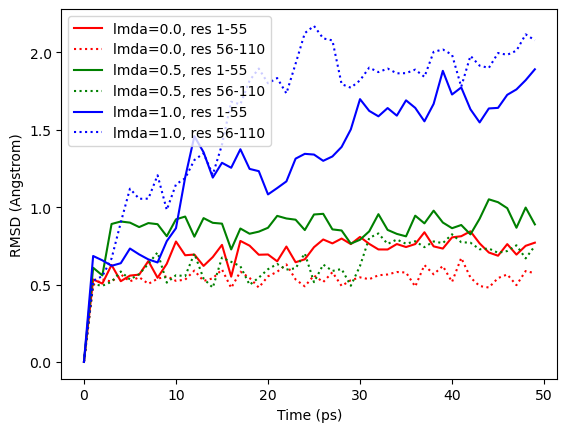

In [5]:
colours = {0.0:'r', 0.25:'orange', 0.5:'g', 0.75:'pink', 1.0:'b'}

for l in [0.0, 0.5, 1.0]: 
    
    plt.plot(rmsd0_data[l], label=f"lmda={l}, res 1-55", c=colours[l])
    plt.plot(rmsd1_data[l], label=f"lmda={l}, res 56-110", linestyle='dotted', c=colours[l])

plt.ylabel('RMSD (Angstrom)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()

#### Two restraints containers

In [12]:
mols = sr.load('structures/BD2_merged.bss')
mols = mols["molecule property is_perturbable"]
mols = sr.morph.link_to_reference(mols)

RMSD_restraints = sr.restraints.rmsd(mols, atoms='atomname CA, C, N and resnum 1:55', k="50 kcal mol-1 A-2", name="RMSD")
restraints1 = sr.restraints.rmsd(mols, atoms='atomname CA, C, N and resnum 56:110', k="50 kcal mol-1 A-2", name='const_restr')

# Create lambda schedule
l = sr.cas.LambdaSchedule()
l.add_stage("turn_off_rmsd_restraints", l.initial())
l.set_equation(stage="turn_off_rmsd_restraints", lever="RMSD",
               equation=1-l.lam())

rmsd0_data = {} # Store sampled RMSD values for res 1-55
rmsd1_data = {} # Store sampled RMSD values for res 45-110

l_values = [0.0, 0.5, 1.0]

for lambda_value in l_values:

    # turn l into the lambda value by dividing by 100
    lambda_value = np.round(lambda_value, 4)
    print(f"\nSimulating lambda={lambda_value:.2f}")

    # Save starting input file
    # sr.save(mols, f"traj_files/lambda{int(10*lambda_value)}", format=["prmtop", "inpcrd"])

    mols = mols.minimisation(lambda_value=lambda_value, schedule=l, restraints=[RMSD_restraints, restraints1]).run().commit()
    d = mols.dynamics(timestep="2fs", temperature="25oC", restraints=[RMSD_restraints, restraints1], schedule=l,
                            lambda_value=lambda_value)
    
    d.randomise_velocities() 
    # d.run("5ps", save_frequency=0)
    d.run("50ps", "1ps")
    mols = d.commit()

    RMSD0 = obtain_rmsd(mols, selection_str='atomname CA, C, N and resnum 1:55')
    rmsd0_data[lambda_value] = RMSD0

    RMSD1 = obtain_rmsd(mols, selection_str='atomname CA, C, N and resnum 56:110')
    rmsd1_data[lambda_value] = RMSD1   

    mols.delete_all_frames()

dynamics                  17 s 1436.2 steps / s          


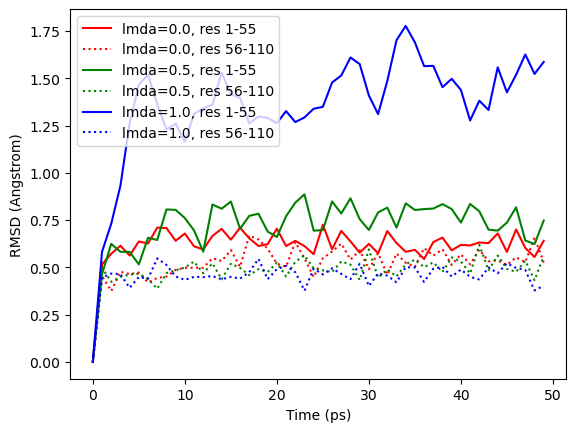

In [13]:
colours = {0.0:'r', 0.25:'orange', 0.5:'g', 0.75:'pink', 1.0:'b'}

for l in [0.0, 0.5, 1.0]: 
    
    plt.plot(rmsd0_data[l], label=f"lmda={l}, res 1-55", c=colours[l])
    plt.plot(rmsd1_data[l], label=f"lmda={l}, res 56-110", linestyle='dotted', c=colours[l])

plt.ylabel('RMSD (Angstrom)')
plt.xlabel('Time (ps)')
plt.legend()
plt.show()